In [4]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
import pickle
from tensorflow.keras.optimizers import RMSprop


2021-11-22 15:59:38.152566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2021-11-22 15:59:38.152605: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
path = 'data.txt'
text = open(path).read().lower()
print('length of the corpus is: :', len(text))

length of the corpus is: : 581888


In [6]:


chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [7]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(len(sentences))

X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

193950


In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

2021-11-22 15:59:45.743991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2021-11-22 15:59:45.744017: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-22 15:59:45.744033: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP-Laptop-15-da0xxx-def03a20): /proc/driver/nvidia/version does not exist
2021-11-22 15:59:45.744236: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history


/home/dhanyaharish/Documents/GitHub/deep-learning/pytorch/DL/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-11-22 15:59:51.044962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-22 15:59:51.063160: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2899885000 Hz


Epoch 1/2
1440/1440 [==============================] - 95s 65ms/step - loss: 1.9598 - accuracy: 0.4237 - val_loss: 2.0956 - val_accuracy: 0.4207
Epoch 2/2
1440/1440 [==============================] - 97s 67ms/step - loss: 1.6166 - accuracy: 0.5161 - val_loss: 2.0504 - val_accuracy: 0.4375


In [10]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

In [13]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)


def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

def predict_completions(text, n=3):
    x = prepare_input(text)
    #print("gf")
    preds = model.predict(x, verbose=0)[0]
    #print("fg")
    next_indices = sample(preds, n)
    print(text)
    print(predict_completion(text[1:]))
#     print(indices_char[16]+predict_completion(text[1:]+indices_char[16]))
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [14]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]


for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
it is not a lack of love, but a lack of 
hrsptcusiyo 
['the ', 'his ', 'me. ', 'a ', 'it ']

that which does not kill us makes us str
that which does not kill us makes us str
ng 
['eet, ', 'ing ', 'ong ', 'anger ', 'uck ']

i'm not upset that you lied to me, i'm u
i'm not upset that you lied to me, i'm u
dtlsoke,yrsase 
['pon ', 's ', 'nderstand ', 'ghto ', 'lled ']

and those who were seen dancing were tho
and those who were seen dancing were tho
elrsaybesate 
['ught ', 'se ', 're ', 'ing ', 'od ']

it is hard enough to remember my opinion
it is hard enough to remember my opinion
 
[' of ', 's ', '. ', ', ', 'ally ']



In [48]:
tokenizer = RegexpTokenizer(r'w+')
words = tokenizer.tokenize(text)

In [49]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [50]:
WORD_LENGTH = 5
SEQUENCE_LENGTH=5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['w', 'w', 'w', 'w', 'w']
www


In [19]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [20]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [51]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [52]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

/home/dhanyaharish/Documents/GitHub/deep-learning/pytorch/DL/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


ValueError: Data cardinality is ambiguous:
  x sizes: 184252
  y sizes: 11530
Make sure all arrays contain the same number of samples.

In [23]:
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

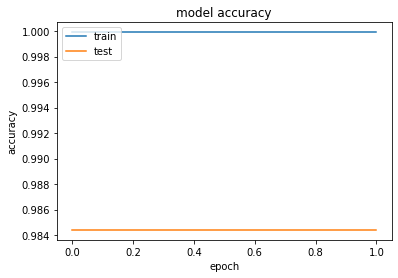

In [24]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

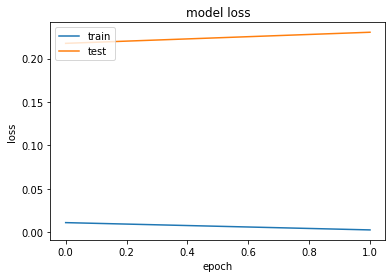

In [25]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [36]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(text)))
    for t, char in enumerate(text):
       x[0, t, char_indices[char]] = 1.
    return x

In [37]:
def sample(preds, top_n=3):
   preds = np.asarray(preds).astype('float64')
   preds = np.log(preds)
   exp_preds = np.exp(preds)
   preds = exp_preds / np.sum(exp_preds)
   return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [38]:
def predict_completions(text, n=3):

    x = prepare_input(text)

    preds = model.predict(x, verbose=0)[0]

    next_indices = sample(preds, n)

    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [39]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [46]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 


TypeError: string indices must be integers